# Model-Based RL
In this exercise you will implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

How are we going to accomplish this in Tensorflow? We are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! 

### Loading libraries and starting CartPole environment

In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

### Setting Hyper-parameters

In [4]:
# hyperparameters
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

### Policy Network

In [5]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]

################################################################################
# TODO: Implement the loss function.                                           #
# This sends the weights in the direction of making actions that gave good     #
# advantage (reward overtime) more likely, and actions that didn't less likely.#
################################################################################
loss = -tf.reduce_mean((input_y*tf.log(probability) + (1 - input_y) * tf.log(1 - probability)) * advantages)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [6]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [7]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer

def discount_rewards(r):
    ################################################################################
    # TODO: Implement the discounted rewards function                              #
    # Return discounted rewards weighed by gamma. Each reward will be replaced     #
    # with a weight reward that involves itself and all the other rewards occuring #
    # after it. The later the reward after it happens, the less effect it has on   #
    # the current rewards's discounted reward                                      #
    # Hint: [r0, r1, r2, ..., r_N] will look someting like:                        #
    #       [(r0 + r1*gamma^1 + ... r_N*gamma^N), (r1 + r2*gamma^1 + ...), ...]    #
    ################################################################################
    discount_r = np.zeros_like(r)
    tmp = 0
    for t in reversed(range(len(r))):
        tmp = tmp * gamma + r[t]
        discount_r[t] = tmp
    return discount_r
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

## Training the Policy and Model

In [10]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                
                ################################################################################
                # TODO: Run the model network and compute predicted_state                      #
                # Output: 'pState'                                                             #
                ################################################################################
                
                actions = np.array(epy[:-1])
                prev_states = np.hstack([epx[:-1, :], actions])
                next_states = epx[1:, :]
                rewards = np.array(epr[1:, :])
                dones = np.array(epd[1:, :])
                state_nextsAll = np.hstack([next_states, rewards, dones])
                
                loss, pState, info = sess.run([model_loss, predicted_state, updateModel], feed_dict=
                                             {previous_state: prev_states, true_observation: next_states,
                                             true_reward: rewards, true_done: dones})
                
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                

            if trainThePolicy == True:
                
                ################################################################################
                # TODO: Run the policy network and compute newGrads                            #
                # Output: 'tGrad'                                                              #
                ################################################################################
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                tGrad = sess.run(newGrads, feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    
                    ################################################################################
                    # TODO:                                                                        #
                    # (1) Run the policy network and update gradients                              #
                    # (2) Reset gradBuffer to 0                                                    #
                    ################################################################################
                    _ = sess.run(updateGrads, feed_dict={W1Grad: gradBuffer[0], W2Grad: gradBuffer[1]})
                    for ix,grad in enumerate(tGrad):
                        gradBuffer[ix] = 0
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes
                if episode_number > 100:
                    
                    ################################################################################
                    # TODO: Alternating between training the policy from the model and training    #
                    # the model from the real environment.                                         #
                    ################################################################################
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4.000000. Reward 13.000000. action: 0.000000. mean reward 13.000000.
World Perf: Episode 7.000000. Reward 29.000000. action: 0.000000. mean reward 13.160000.
World Perf: Episode 10.000000. Reward 17.000000. action: 1.000000. mean reward 13.198400.
World Perf: Episode 13.000000. Reward 13.333333. action: 0.000000. mean reward 13.199749.
World Perf: Episode 16.000000. Reward 16.333333. action: 0.000000. mean reward 13.231085.
World Perf: Episode 19.000000. Reward 15.666667. action: 1.000000. mean reward 13.255441.
World Perf: Episode 22.000000. Reward 21.000000. action: 1.000000. mean reward 13.332887.
World Perf: Episode 25.000000. Reward 17.333333. action: 0.000000. mean reward 13.372891.
World Perf: Episode 28.000000. Reward 21.666667. action: 1.000000. mean reward 13.455829.
World Perf: Episode 31.000000. Reward 20.000000. action: 0.000000. mean reward 13.521271.
World Perf: Episode 34.000000. Reward 25.333333. action: 1.000000. mean reward 13.639391.
World Perf: 

World Perf: Episode 280.000000. Reward 37.000000. action: 0.000000. mean reward 23.374975.
World Perf: Episode 283.000000. Reward 58.000000. action: 0.000000. mean reward 23.576014.
World Perf: Episode 286.000000. Reward 33.000000. action: 0.000000. mean reward 23.505333.
World Perf: Episode 289.000000. Reward 36.666667. action: 0.000000. mean reward 23.980116.
World Perf: Episode 292.000000. Reward 47.000000. action: 0.000000. mean reward 24.017258.
World Perf: Episode 295.000000. Reward 27.333333. action: 0.000000. mean reward 25.975153.
World Perf: Episode 298.000000. Reward 27.333333. action: 0.000000. mean reward 25.814056.
World Perf: Episode 301.000000. Reward 38.333333. action: 1.000000. mean reward 25.747160.
World Perf: Episode 304.000000. Reward 36.000000. action: 1.000000. mean reward 29.135042.
World Perf: Episode 307.000000. Reward 15.666667. action: 0.000000. mean reward 29.065519.
World Perf: Episode 310.000000. Reward 50.000000. action: 0.000000. mean reward 32.251881.

Z:\python-3.5.3.amd64\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in greater


World Perf: Episode 403.000000. Reward 9.333333. action: 0.000000. mean reward 39.915874.
World Perf: Episode 406.000000. Reward 8.333333. action: 0.000000. mean reward 39.256382.
World Perf: Episode 409.000000. Reward 9.666667. action: 0.000000. mean reward 38.611347.
World Perf: Episode 412.000000. Reward 9.333333. action: 0.000000. mean reward 38.014713.
World Perf: Episode 415.000000. Reward 9.333333. action: 0.000000. mean reward 37.520756.
World Perf: Episode 418.000000. Reward 10.000000. action: 0.000000. mean reward 37.037193.
World Perf: Episode 421.000000. Reward 9.000000. action: 0.000000. mean reward 36.493370.
World Perf: Episode 424.000000. Reward 9.000000. action: 0.000000. mean reward 37.606239.
World Perf: Episode 427.000000. Reward 9.000000. action: 0.000000. mean reward 37.071880.
World Perf: Episode 430.000000. Reward 9.666667. action: 0.000000. mean reward 36.504356.
World Perf: Episode 433.000000. Reward 9.000000. action: 0.000000. mean reward 35.922554.
World Per

World Perf: Episode 676.000000. Reward 8.666667. action: 0.000000. mean reward 14.283013.
World Perf: Episode 679.000000. Reward 9.666667. action: 0.000000. mean reward 14.130467.
World Perf: Episode 682.000000. Reward 9.333333. action: 0.000000. mean reward 13.984820.
World Perf: Episode 685.000000. Reward 9.000000. action: 0.000000. mean reward 13.840810.
World Perf: Episode 688.000000. Reward 9.000000. action: 0.000000. mean reward 13.680139.
World Perf: Episode 691.000000. Reward 9.666667. action: 0.000000. mean reward 13.546719.
World Perf: Episode 694.000000. Reward 9.000000. action: 0.000000. mean reward 13.402394.
World Perf: Episode 697.000000. Reward 10.333333. action: 0.000000. mean reward 13.266300.
World Perf: Episode 700.000000. Reward 9.666667. action: 0.000000. mean reward 13.152451.
World Perf: Episode 703.000000. Reward 8.666667. action: 0.000000. mean reward 13.007954.
World Perf: Episode 706.000000. Reward 9.000000. action: 0.000000. mean reward 12.875732.
World Per

World Perf: Episode 961.000000. Reward 8.666667. action: 0.000000. mean reward 7.557023.
World Perf: Episode 964.000000. Reward 9.666667. action: 0.000000. mean reward 7.529395.
World Perf: Episode 967.000000. Reward 9.000000. action: 0.000000. mean reward 7.507473.
World Perf: Episode 970.000000. Reward 10.000000. action: 0.000000. mean reward 7.491014.
World Perf: Episode 973.000000. Reward 9.333333. action: 0.000000. mean reward 7.472390.
World Perf: Episode 976.000000. Reward 9.000000. action: 0.000000. mean reward 7.443005.
World Perf: Episode 979.000000. Reward 8.666667. action: 0.000000. mean reward 7.412740.
World Perf: Episode 982.000000. Reward 9.666667. action: 0.000000. mean reward 7.397430.
World Perf: Episode 985.000000. Reward 9.000000. action: 0.000000. mean reward 7.374133.
World Perf: Episode 988.000000. Reward 9.666667. action: 0.000000. mean reward 7.354042.
World Perf: Episode 991.000000. Reward 9.333333. action: 0.000000. mean reward 7.345555.
World Perf: Episode 

World Perf: Episode 1237.000000. Reward 9.666667. action: 0.000000. mean reward 6.552010.
World Perf: Episode 1240.000000. Reward 9.666667. action: 0.000000. mean reward 6.550526.
World Perf: Episode 1243.000000. Reward 10.000000. action: 0.000000. mean reward 6.551502.
World Perf: Episode 1246.000000. Reward 9.333333. action: 0.000000. mean reward 6.554143.
World Perf: Episode 1249.000000. Reward 9.666667. action: 0.000000. mean reward 6.548720.
World Perf: Episode 1252.000000. Reward 9.333333. action: 0.000000. mean reward 6.543293.
World Perf: Episode 1255.000000. Reward 10.000000. action: 0.000000. mean reward 6.547290.
World Perf: Episode 1258.000000. Reward 9.666667. action: 0.000000. mean reward 6.549929.
World Perf: Episode 1261.000000. Reward 8.666667. action: 0.000000. mean reward 6.530840.
World Perf: Episode 1264.000000. Reward 9.333333. action: 0.000000. mean reward 6.517955.
World Perf: Episode 1267.000000. Reward 8.666667. action: 0.000000. mean reward 6.510105.
World Pe

World Perf: Episode 1525.000000. Reward 9.333333. action: 0.000000. mean reward 6.276629.
World Perf: Episode 1528.000000. Reward 9.333333. action: 0.000000. mean reward 6.271269.
World Perf: Episode 1531.000000. Reward 9.666667. action: 0.000000. mean reward 6.272444.
World Perf: Episode 1534.000000. Reward 8.666667. action: 0.000000. mean reward 6.270429.
World Perf: Episode 1537.000000. Reward 9.333333. action: 0.000000. mean reward 6.265778.
World Perf: Episode 1540.000000. Reward 9.000000. action: 0.000000. mean reward 6.252308.
World Perf: Episode 1543.000000. Reward 10.333333. action: 0.000000. mean reward 6.263121.
World Perf: Episode 1546.000000. Reward 9.666667. action: 0.000000. mean reward 6.264397.
World Perf: Episode 1549.000000. Reward 9.333333. action: 0.000000. mean reward 6.265284.
World Perf: Episode 1552.000000. Reward 9.333333. action: 0.000000. mean reward 6.261797.
World Perf: Episode 1555.000000. Reward 9.333333. action: 0.000000. mean reward 6.261104.
World Per

World Perf: Episode 1798.000000. Reward 10.000000. action: 0.000000. mean reward 6.267580.
World Perf: Episode 1801.000000. Reward 9.333333. action: 0.000000. mean reward 6.267061.
World Perf: Episode 1804.000000. Reward 9.333333. action: 0.000000. mean reward 6.271071.
World Perf: Episode 1807.000000. Reward 9.666667. action: 0.000000. mean reward 6.275923.
World Perf: Episode 1810.000000. Reward 8.333333. action: 0.000000. mean reward 6.265750.
World Perf: Episode 1813.000000. Reward 9.333333. action: 0.000000. mean reward 6.269549.
World Perf: Episode 1816.000000. Reward 9.333333. action: 0.000000. mean reward 6.272049.
World Perf: Episode 1819.000000. Reward 9.000000. action: 0.000000. mean reward 6.269500.
World Perf: Episode 1822.000000. Reward 9.000000. action: 0.000000. mean reward 6.267622.
World Perf: Episode 1825.000000. Reward 9.333333. action: 0.000000. mean reward 6.261657.
World Perf: Episode 1828.000000. Reward 9.333333. action: 0.000000. mean reward 6.256993.
World Per

World Perf: Episode 2068.000000. Reward 9.000000. action: 0.000000. mean reward 6.201977.
World Perf: Episode 2071.000000. Reward 9.000000. action: 0.000000. mean reward 6.190609.
World Perf: Episode 2074.000000. Reward 9.666667. action: 0.000000. mean reward 6.192693.
World Perf: Episode 2077.000000. Reward 10.333333. action: 0.000000. mean reward 6.205490.
World Perf: Episode 2080.000000. Reward 8.666667. action: 0.000000. mean reward 6.202734.
World Perf: Episode 2083.000000. Reward 9.333333. action: 0.000000. mean reward 6.210129.
World Perf: Episode 2086.000000. Reward 9.000000. action: 0.000000. mean reward 6.211143.
World Perf: Episode 2089.000000. Reward 9.333333. action: 0.000000. mean reward 6.211594.
World Perf: Episode 2092.000000. Reward 9.000000. action: 0.000000. mean reward 6.204977.
World Perf: Episode 2095.000000. Reward 9.666667. action: 0.000000. mean reward 6.201677.
World Perf: Episode 2098.000000. Reward 10.000000. action: 0.000000. mean reward 6.211507.
World Pe

World Perf: Episode 2359.000000. Reward 9.333333. action: 0.000000. mean reward 6.195322.
World Perf: Episode 2362.000000. Reward 9.333333. action: 0.000000. mean reward 6.200953.
World Perf: Episode 2365.000000. Reward 9.000000. action: 0.000000. mean reward 6.200150.
World Perf: Episode 2368.000000. Reward 9.666667. action: 0.000000. mean reward 6.201057.
World Perf: Episode 2371.000000. Reward 9.000000. action: 0.000000. mean reward 6.194139.
World Perf: Episode 2374.000000. Reward 9.666667. action: 0.000000. mean reward 6.193263.
World Perf: Episode 2377.000000. Reward 9.333333. action: 0.000000. mean reward 6.194401.
World Perf: Episode 2380.000000. Reward 9.000000. action: 0.000000. mean reward 6.187789.
World Perf: Episode 2383.000000. Reward 10.000000. action: 0.000000. mean reward 6.192464.
World Perf: Episode 2386.000000. Reward 9.000000. action: 0.000000. mean reward 6.181313.
World Perf: Episode 2389.000000. Reward 9.666667. action: 0.000000. mean reward 6.180180.
World Per

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

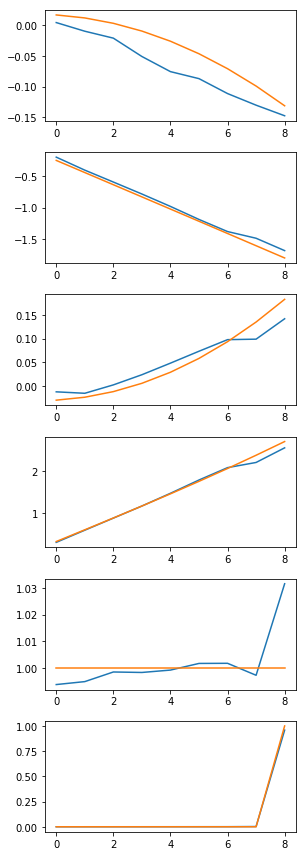

In [11]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()